In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.io import imread_collection
from ast import Yield
import matplotlib.pyplot as plt
import glob
import cv2
import os

In [ ]:
height= 80
width=200

In [48]:
train_path = 'data/train/*.png'
val_path = 'data/validation/*.png'
y_path = 'data/train.csv'
y_val_path ='data/validation.csv'
# Y_train = np.loadtxt('data/train.csv', delimiter=',', skiprows=1, usecols=1)
Y_train = pd.read_csv(y_path)
# Y_val = np.loadtxt('data/validation.csv', delimiter=',', skiprows=1, usecols=1)
Y_val = pd.read_csv(y_val_path)
#creating a collection with the available images
train = imread_collection(train_path)
val = imread_collection(val_path)


# X = [color.rgb2gray(image).ravel() for image in train]
X_train=[]
X_val=[]
for image in train:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    flatten = gray.ravel()
    # thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    # Normalize pixel values to the range [0, 1]
    normalized_image = (flatten - flatten.min()) / (flatten.max() - flatten.min())


    X_train.append(normalized_image)

for image in val:
    roi = image[0:80, 0:200]
    grayscale_image = color.rgb2gray(roi)
    flattened_image = grayscale_image.ravel()

    # Normalize pixel values to the range [0, 1]
    normalized_image = (flattened_image - flattened_image.min()) / (flattened_image.max() - flattened_image.min())


    X_val.append(roi)

X_val =np.array(X_val).reshape(-1, height, width, 1)
X_train = np.array(X_train).reshape(-1, height, width, 1)

In [68]:
window =33
X_train=[]
X_val=[]

for image in val:

    for x in range (0,image.shape[1]-window,window):
        roi = image[0:80, x:x+window]
        grayscale_image = color.rgb2gray(roi)
        flattened_image = grayscale_image.ravel()

        # Normalize pixel values to the range [0, 1]
        normalized_image = (flattened_image - flattened_image.min()) / (flattened_image.max() - flattened_image.min())


        X_val.append(roi)

In [ ]:
# import cv2
# from skimage.io import imread_collection
# import numpy as np
# import pandas as pd

# # Update file paths using forward slashes or raw string
# train_path = 'data/train/*.png'
# val_path = 'data/validation/*.png'
# y_path = 'data/train.csv'
# y_val_path ='data/validation.csv'

# # Read training images
# X_train = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in glob.glob(train_path)]

# Y_train = pd.read_csv(y_path)

# y_val = pd.read_csv(y_val_path)

# # Read validation images using imread_collection
# X_val = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in glob.glob(val_path)]

# # If you want to convert the validation images to a numpy array
# X_val_array = np.array(X_val)/255




IndexError: list index out of range

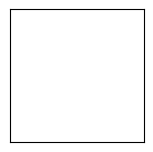

In [61]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    label = Y_train.iloc[i]['Label']
    plt.title(f'Label is {label}')


plt.show()

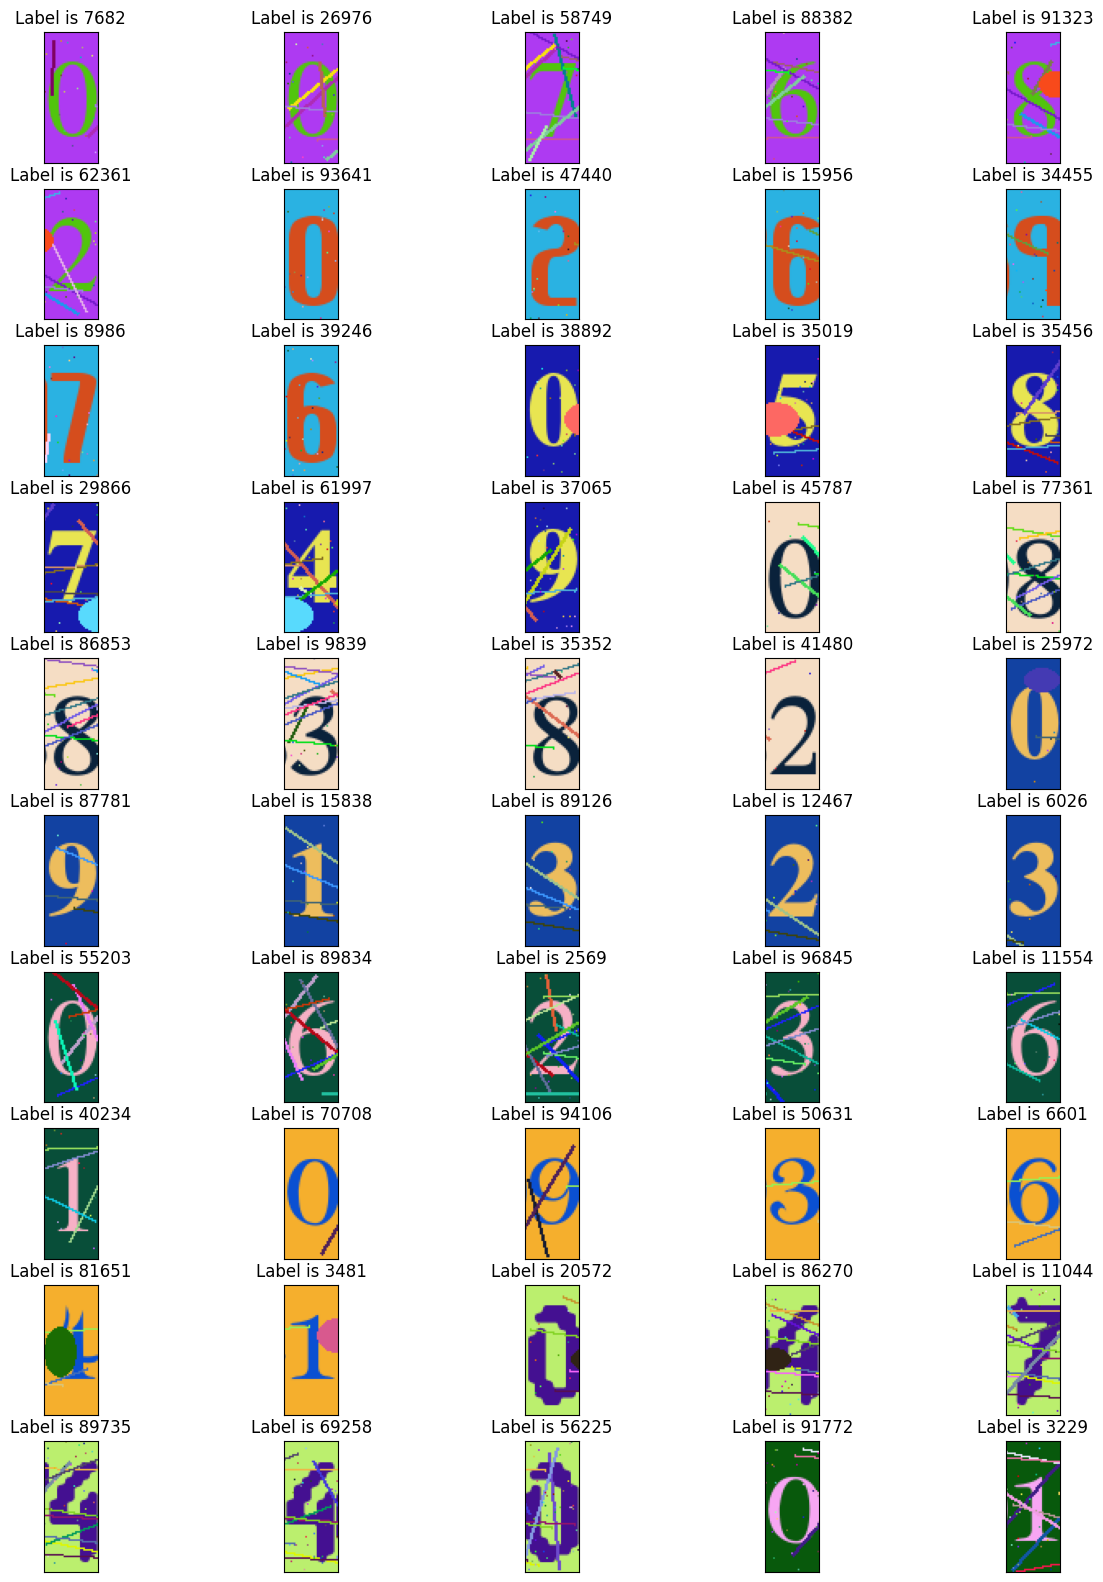

In [69]:
plt.figure(figsize=(15,20))
for i in range(50):
    plt.subplot(10,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_val[i])
    label = Y_val.iloc[i]['Label']
    plt.title(f'Label is {label}')


plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

Y_train_labels = Y_train['Label'].to_numpy()
y_combine = LabelEncoder().fit_transform(Y_train_labels)
y_one_hot = OneHotEncoder().fit_transform(y_combine.reshape(len(y_combine),1))

In [ ]:
from keras.utils import to_categorical
Y_train_one_hot = to_categorical(Y_train)
Y_val_one_hot = to_categorical(Y_val)

In [ ]:
X_train= np.array(X_train)
print(X_train.shape)
print(X_val.shape)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

model = Sequential()
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(80,200,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(99987, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, Y_train_one_hot, validation_data=(X_val, Y_val_one_hot), epochs=3)